# Time Series Basics

## Background
Up until now we've dealt with data whose samples (i.e. rows of `X`) did not depend on each other. Such data is often referred to as IID, i.e. independent and identically distributed. This means that the samples are independent (they don't depend on each other), and they are all generated from the same underlying probability distribution. With IID data, shuffling the samples or randomly subsampling from them doesn't change the underlying distribution. This is why we could create training and test sets by just randomly sampling some data for training and some data for testing.

Now we'll spend some time talking about how to deal with situations where time dependencies do occur in the data. These types of data are called _time series_. Time series differ from IID data in that there is a natural order in the data, usually time. The order of samples in the dataset does matter. In a time series dataset it's typical for a sample to depend on data taken at previous times (so samples are not independent), and for data taken at different times to have different underlying distributions (so samples are not identically distributed). Samples are only allowed to depend on previous times (and not future times) because time series are _causal_, meaning the future can't be allowed to affect the past.

In math speak, the difference between IID data and time series data is as follows. Note if this looks like gibberish to you just ignore it. You can get along fine with the above intuitive definition.
- If the input dataset $X=\{ x_1,x_2,\cdots,x_n\}$ is IID, then each sample $x_i$ has the same distribution $p(x)$, and independence means $p(x_i,x_j)=p(x_i)p(x_j)$ when $i\neq j$. 
- If the input dataset $X=\{ x_1,x_2,\cdots,x_T\}$ is a time series with time indexes $t=1,\cdots,T$, then $X$ forms a discrete-time [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) where each $x_t$ is distributed with some t-dependent distribution $p_t(x)$. Moreover, $X$ is causal, meaning $x_t$ is completely independent of future values, i.e. $p(x_t,x_s)=p_t(x_t)p_s(x_s)$ when $s\geq t$, but $x_t$ is only conditionally independent given previous values $x_1,\cdots,x_{t-1}$, i.e. 
$$p(x_t,x_{t-1},\cdots,x_2,x_1)=p(x_t|x_{t-1},\cdots,x_1,x_2)p(x_{t-1},\cdots,x_2,x_1).$$

Side remark: One can also imagine continuous-time processes as well. This leads to the far more sophisticated topics of continuous-time stochastic processes and [stochastic differential equations](https://en.wikipedia.org/wiki/Stochastic_differential_equation). Since in practices we only ever have a finite amount of data though, we can always assume for our purposes that time is discrete.

## Getting Started
In this notebook, we'll very briefly talk about visualizing, filtering, decomposing, and forecasting simple (univariate) time series. Many of these techniques form the building block for more advanced time series ML techniques. Note if you've never worked with time series before this may feel like getting sprayed with a fire hose. Just go through it as many times as you need to to get an idea what the big picture is.

We've already worked with the `pandas` library a little bit before. Now we'll actually get to see some of the cool functionality that pandas has for working with time series data. We'll also be working with a new library, `statsmodels`, that contains many time series analysis tools. We'll also work with the less well known library `stldecompose` for doing STL decompositions (which statsmodels doesn't yet support sadly). The only functions we'll predefine are functions for importing the data. By default we'll be working with the `get_data` function, which loads in a "live" dataset, but feel free to play around on your own with the `custom_data` function, which allows you to create your own time series.

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import naive, drift, mean, seasonal_naive

np.random.seed(23)

In [148]:
def custom_data(trange,period):
    t = np.linspace(0,trange,1000)
    f = lambda t: (0.0003*t+.08*np.sin(2*np.pi/period*t))*len(t)
    x = f(t) + .03*len(t)*np.random.normal(0,1,len(t))
    df = pd.DataFrame({'t':t,'x':x})
    df = df.set_index('t')
    return df

def get_data():
    df = sm.datasets.co2.load_pandas().data
    df.index = pd.to_datetime(df.index)
    df = df.resample('D').mean().interpolate('linear')
    return df

As usual, we'll begin by loading in our data. The data we'll use is the [Mauna Loa Weekly Atmospheric CO2 Dataset](https://www.statsmodels.org/dev/datasets/generated/co2.html), which contains about 50 years of atmospheric CO2 concentration measurements. The `get_data` function loads in this dataset and does some light processing on the raw data before return a pandas dataframe whose index is time and only feature is `co2`, the CO2 emissions values.

Observe that the index of the dataframe contains the datetime when each measurement was collected. Pandas has a special datetime format that allows users to encode time data in a user-friendly way. Using this format allows you to do things like resample the data by second, minute, hour, day, week, month, or year, which is often very useful when working with time series. By keeping the time information in the dataframe index, pandas automatically keeps things in time-sorted order for you, so doing this is always recommended.

In our particular case, the data was collected once a day, so each entry is a single day. This is called the sampling frequency of the time series, and it's very important to know what this frequency is when working with the data. For instance, since we know the sampling frequency is daily here, and that atmospheric measurements vary by time of year, we can infur that the period of the data, i.e. the time it takes for the series to complete one periodic oscillation, is 365 (since a year is 365 days). Keeping track of the period (or sampling frequency) will be essential for what we do below.

In [193]:
df = get_data()
period = 365
df.head()

,co2
1958-03-29,316.100000
1958-03-30,316.271429
1958-03-31,316.442857
1958-04-01,316.614286
1958-04-02,316.785714


As always, one of the first things you should do with any new data is make plots of it. We do that below using the pandas `plot` method. The first plot is the entire time series. Observe that the x-axis has the correct dates filled in, from 1958 to 2001. This is automatic when we set the index to be the time, and encode the time as a pandas `datetime` object. Looking at the curve itself, we can see a long-term increasing pattern in the data over time. We can also see that the data oscillates with a period of about a year. In time series lingo, the long-term increasing pattern we see is called the _trend_ of the series, and the oscillating pattern we see is called the _seasonality_ of the series.

We can also take a look at a slice of the time series. The second plot below is a plot of the first 1000 values in the time series. Notice in this "zoomed in" view, we can't see the trend very well, but we can clearly spot the seasonality. Indeed, it seems the period (peak to peak time) is about a year. We can also see some random fluctuation in the series at this scale. This fluctuation or noise is called the _residual_ of the time series.

In fact, it turns out that any (additive) time series $x(t)$ can be expressed as the sum of three terms, a trend, a season, and a residual:
$$x(t) = trend(t) + season(t) + resid(t).$$

Remark: Other than trends, seasons, and residuals, there is often in practice another component of a time series called a _cycle_. Cycles are just seasons with irregular (and unpredictable) periods. Trying to isolate a cycle can be pretty hard to do, so it's often easier just to absorb it into the trend. We don't see any cycle present in this dataset, so we ignore it.

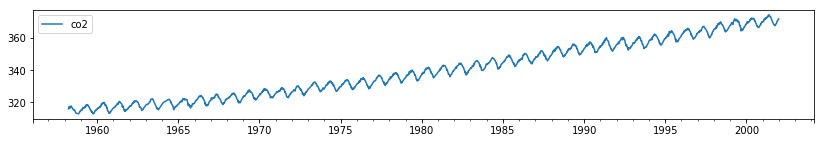

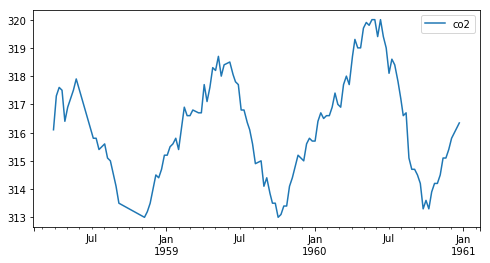

In [150]:
df.plot(figsize=(14,2))
df.head(1000).plot(figsize=(8,4))

One concept that comes up when dealing with time series is the rolling statistic (aka filter or sliding window). Instead of calculating a single statistic (e.g. the mean) for the entire time series, we first define a window size, and slide the window across the time series while computing the desired statistic for values only inside that window. Doing this allows the statistic to vary with the time series. This is related to the concept of smoothing in signal processing, where one applies a filter to a noisy signal to smooth out some of the noise.

One of the most useful rolling statistics to keep track of is the rolling mean (aka moving average). A moving average is just a local average of the time series. To calculate a moving average one first needs to define a window size. It needs to be large enough to "smooth" the data, but not so large that it's not fitting the data well. In our case, we choose a window size of 100. Below we use the pandas `rolling(window_size)` method to calculate rolling statistics. Plotting the rolling mean against the raw data, we can see the rolling mean is much smoother than the raw data. Also, observe the rolling mean is shifted slightly to the right. This is due to bias, which gets worse when you have larger window sizes. Trading off between smoothness and bias is a common issue.

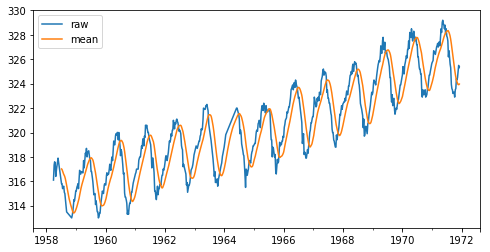

In [214]:
fig, ax = plt.subplots(figsize=(8,4))
df.head(5000).plot(ax=ax)
df.rolling(100).mean().head(5000).plot(ax=ax)
ax.legend(['raw','mean'])
plt.show()

ML models work best when the data is IID. In time series lingo IID data is called _white noise_. An approximation to white noise is the idea of a _stationary_ time series. A stationary time series is one in which each $x_t$ has the same mean and variance. Visually this means the time series doesn't drift (so no trend or season), and the noise level doesn't change with time. 

It's often a good idea to transform a time series to a new stationary time series before doing ML. There are several ways to do this. One simple way is to difference the data. That is, for each point $x_t$, we replace it with a new point defined by $\delta_t = x_t-x_{t-1}$. This gives a new time series $\Delta=\{\delta_1,\cdots,\delta_T \}$ that is completely equivalent to the old time series $X$. We can transform back and forth between the two at will.

In pandas, we can difference a time series using the `diff` method. Below is a plot of the differenced time series. Notice it's hard to see any clear trend or season in the data, which was the whole point. Making a time series stationary is as close to IID as you're going to get. 

Note the difference we just defined is technically the first difference. We calculate the difference between any two time series points we like though. The $k^{th}$ difference at time $t$ is given by $\delta_t = x_t-x_{t-k}$. One type of k differencing that might be useful is when k is the period. This helps remove seasonality from the series. We can also take higher order differences as well if the data doesn't look stationary enough. If you take enough differences eventually the time series will appear stationary.

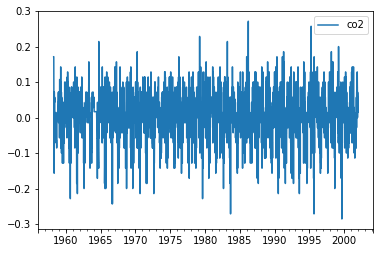

In [215]:
diffs = df.diff().dropna()
diffs.plot()

## Autocorrelations

One of the most important things to know about a time series is how much points depend on previous points in the series. This dependence can be measured using [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation). Autocorrelation is the correlation of a series with a lagged (i.e. delayed) copy of itself. Just like the usual correlation, it takes values between -1 and 1. The closer the autocorrelation between two points is to 0, the less they depend on each other. The closer it is to 1 or -1 the more they depend on each other.

Autocorrelations can be useful when deciding how much one should pay attention to _lag features_, i.e. delayed copies of the time series, when doing ML. The more previous points a given point depends on, the higher the autocorrelation is, and hence the more lag features you need to capture the dependence in your data.

We can visualize autocorrelations with a plot. This helps us quickly spot how much we need to worry about long-term time dependencies in the data. The `statsmodels.graphics.tsaplots` library has a nifty `plot_acf` function that can do all this work for us. In this plot, each point $(x,y)$ represents the autocorrelation of a point in the series with its lag-$x$ value, with their autocorrelation value given by $y$. 

Below we see two examples of the extreme cases of autocorrelation. In the first case we look at the autocorrelation of pure white noise data. We can see in this case that there is no significant dependence on past values. In fact, each point appears to depend only on its lag-0 value, i.e. on itself (which is always true). In the second case we look at the autocorrelation of a non-random function $x(t)=t$. In this case, we can see the autocorrelation function is going to zero only very slowly, which means there are long-term dependencies present.

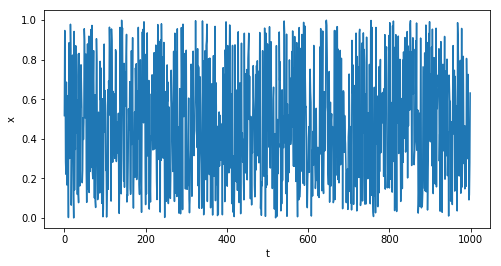

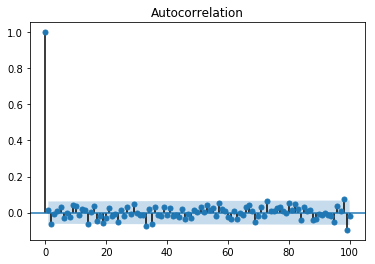

In [217]:
x = np.random.rand(1000)
fig = plt.figure(figsize=(8,4))
plt.plot(x)
plt.ylabel('x')
plt.xlabel('t')
fig = plot_acf(x, lags=100)
plt.show()

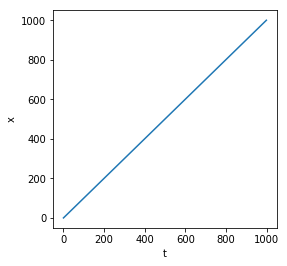

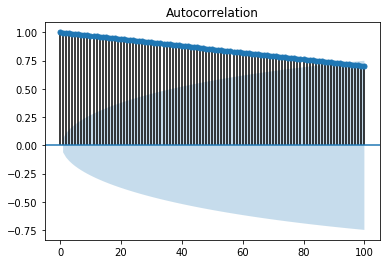

In [216]:
x = np.linspace(0,1000,1000)
fig = plt.figure(figsize=(4,4))
plt.plot(x)
plt.ylabel('x')
plt.xlabel('t')
fig = plot_acf(x, lags=100)
plt.show()

We now look at the autocorrelation plot for our CO2 data. In the first case, we calculate the plot for the raw data. We can see that there are very long-term dependencies here, with significant dependence at least up to around 1500 lags (where the points cross under the blue half-oval). We certainly wouldn't want to create 1500 new lag features to do ML. A better strategy would be to first difference the data and see how much autocorrelation remains. Doing that we see that lags only up to about 20 are significant with the differenced data. Creating 20 lag features is much more feasible than creating 1500! Note we can also try repeated differencing (or differencing by the period) to reduce the lag dependence even further.

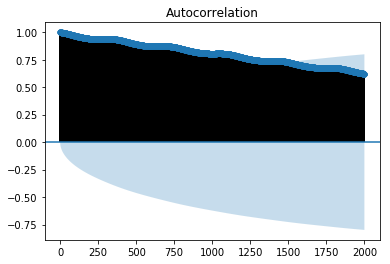

In [29]:
fig = plot_acf(df, lags=2000)
plt.show()

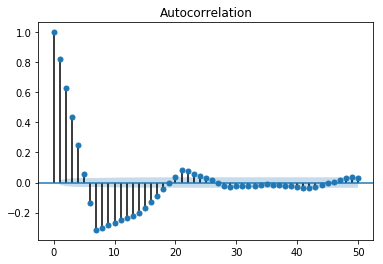

In [42]:
diffs = df.diff(periods=period).diff()
fig = plot_acf(diffs.dropna(), lags=50)
plt.show()

## Time Series Decompositions

I mentioned that any time series can be decomposed into three components: a trend, a season, and a residual. There are algorithms out there that can attempt to do this automatically for us. These are called seasonal-trend decomposition algorithms. The main difference between these algorithms is how they seperate the trend and seasonal components from each other. The most basic ST-decomposition can be done using the `seasonal_decompose` function in `statsmodels.tsa.seasonal`. Observe that one must specify the period for this to work, which is why it's so important to know this (or guess it) from the data. 

A plot of the decompositions is shown below. We can see a mostly linear trend, along with the year-periodic season, and the residual (what's left over) which looks something like white noise.

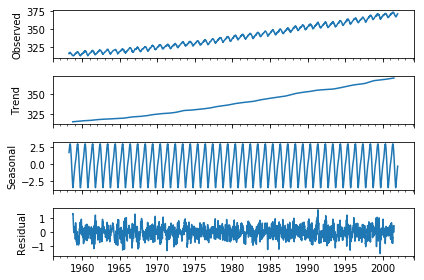

In [126]:
decomp = seasonal_decompose(df,freq=period)
fig = decomp.plot()
plt.show()

The most popular method for doing ST-decompositions is seasonal-trend with Loess decomposition, aka STL. STL is far more robust than the classical version above, and is probably your best go to option for doing decompositions. Unfortunately, neither `statsmodels` nor any other major Python package supports STL yet, so we use a not-well-known package `stldecompose` for this. The API is mostly the same. 

We can see a similar decomposition to the above classical method. The main difference seems to be that the residuals look different, showing more stickiness.

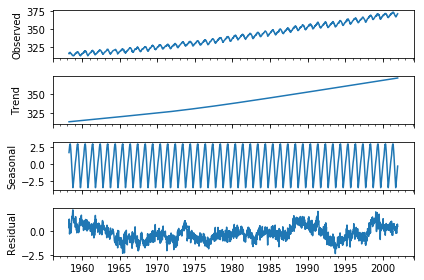

In [130]:
stl = decompose(df.x, period=period)
stl.plot()
plt.show()

We can use ST-decompositions to do all kinds of neat things, including forecasting and outlier detection. [Forecasting](https://en.wikipedia.org/wiki/Forecasting) is the process of making predictions of future values of the time series using past values. Forecasting is a very important subfield of time series analysis, and is used like crazy in fields like marketing (predicting future sales) or finance (predicting the stock market). Pretty much any time you want to use the past to predict the future you're doing forecasting, so it's important to know about.

There are many forecasting techniques out there (including using ML, which we'll see later). One can forecast pretty simply though just using ST-decompositions. We do that below STL. Namely, we take the first two-thirds of the data and try to forecast the values of the last third, and then see how well we did.

To make a forecast, we first take an STL decomposition of the first two-thirds of the data, called `past_vals`, and then forecast for the next 8000 steps (i.e. the last third of the data). Different inputs to `fc_func` will forecast in different ways. Options include naive, mean, drift, and seasonal_naive. The best one is probably drift, which is able to capture the increasing trend. Setting `seasonal=True` also allows the forecast function to capture the seasonal behavior as well.

The plot below shows the past values in orange and the (true) future values in blue, with the forecasted values shown in green. We can see that using drift with seasonal set to true gives a very good forecast. Why? Because this data is pretty easily predictable. Try doing this with the stock market though and it won't work very well at all.

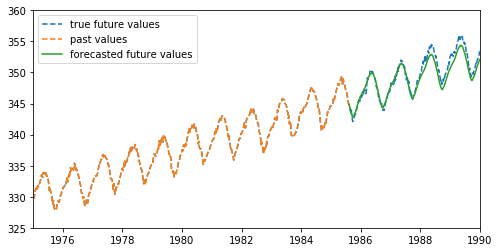

In [218]:
past_vals = df.head(10000)
past_stl = decompose(short_obs, period=365)
fcast = forecast(past_stl, steps=8000, fc_func=drift, seasonal=True) # fc_func=mean,drift,naive,seasonal_naive

fig = plt.figure(figsize=(8,4))
plt.plot(df, '--', label='true future values')
plt.plot(past_vals, '--', label='past values')
plt.plot(fcast, '-', label='forecasted future values')
plt.xlim('1975','1990')
plt.ylim(325,360)
plt.legend()
plt.show()

We finish up ST-decomposition by showing how it can be used for time series anomaly detection as well. What we can do is separate our time series into its three components, and then try to look for outliers in the residuals. There are several ways to do this. The one we do is as follows:

We calculate a rolling mean $\mu$ and rolling standard deviation $\sigma$ of the residuals $r$ with a window-size `window`. We define an anomaly in this case as any value such that $|r-\mu|>4\sigma$. Having values exceed $4\sigma$ roughly means that those values are more extreme than 99.99% of the data inside the rolling window. A plot of these detected anomalies is shown below with red dots. Using a window size of 300 it appears we found 8 anomalies. Moreover, the anomalies found are not at all obvious with the human eye. Could you have identified them?

Number of detected anomalies:  8


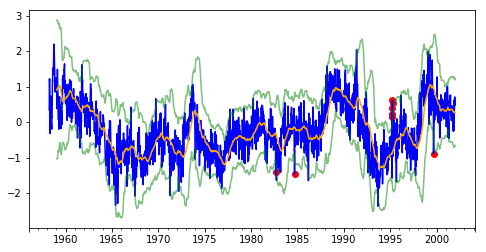

In [189]:
resids = stl.resid
window = 300
mu = resids.rolling(window).mean()
sigma = resids.rolling(window).std()
is_anom = (resids-mu).abs() > 4*sigma # deviates from 99.99% of the data
anomalies = resids[is_anom]
print('Number of detected anomalies: ',len(anomalies))

fig = plt.figure(figsize=(8,4))
resids.plot(color='blue')
(mu-3*sigma).plot(color='green', linestyle='-', alpha=0.5)
(mu+3*sigma).plot(color='green', linestyle='-', alpha=0.5)
mu.plot(color='orange', linestyle='-')
plt.scatter(anomalies.index,anomalies,color='red')
plt.show()

**Reference:** Here's a popular [time series book](https://otexts.org/fpp2/). It gets straight to the point. It's online. And it's free.